In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
import random
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import seaborn as sns
from scipy.signal import spectrogram

## Fetch signals from folder

In [3]:
# on my computer root is 'C:\\Users\\amroa\\Documents\\thesis\\data'
def fetch_signals(root, subset = True):
    """
    subset: if True, then get training portion of data
    """
    signals = []
    folder_path = root
    file_list = os.listdir(folder_path)

    # walk inside data folder
    for filename in file_list:
        full_path = os.path.join(folder_path, filename)

        # walk inside data/[number]
        file_nest_list = os.listdir(full_path)
        for filename_1 in file_nest_list:
            if filename_1 != "avt":
                continue
            else:
                # full_path_2 is of the form C:\Users\amroa\Documents\thesis\data\01\avt
                full_path_2 = os.path.join(full_path, filename_1)
                setup_filenames = [filename for filename in os.listdir(full_path_2) if "setup" in filename]
                if subset:
                    random_setup_filename = random.choice(setup_filenames)
                    full_path_3 = os.path.join(full_path_2, random_setup_filename)
                    # full_path_3 is of the form C:\Users\amroa\Documents\thesis\data\01\avt\01setup09.mat
                    avt = loadmat(full_path_3)
                    avt_t = avt['data'].transpose()
                    signals.append(avt_t[0])
                else:
                    for filename_2 in setup_filenames:
                        full_path_3 = os.path.join(full_path_2, random_setup_filename)
                        # full_path_3 is of the form C:\Users\amroa\Documents\thesis\data\01\avt\01setup09.mat
                        avt = loadmat(full_path_3)
                        avt_t = avt['data'].transpose()
                        signals.append(avt_t[1]) ## we can change this to be 1: len(avt_t) but for speed let's keep it at this
    return signals

In [4]:
signals = fetch_signals('C:\\Users\\amroa\\Documents\\thesis\\data', True)

In [5]:
len(signals)

17

## Sample visualization for one signal

In [7]:
## sampling rate of 100 Hz at 65,536 samples
avt = loadmat('./data/03/avt/03setup09.mat')

In [8]:
avt['data']

array([[ 5.249023e-06,  1.138760e-05, -1.712036e-05, ..., -2.412626e-05,
        -3.814697e-05, -3.546143e-05],
       [ 2.258301e-05,  4.535738e-05,  4.211426e-05, ..., -1.003653e-05,
        -6.256104e-05,  1.043701e-05],
       [-2.136230e-05,  2.895152e-06,  4.577637e-07, ..., -1.408974e-05,
        -4.333496e-05,  4.455566e-06],
       ...,
       [-2.393188e-04,  1.412834e-04, -1.678467e-06, ..., -8.106425e-05,
         8.483887e-06, -6.134033e-05],
       [-2.479248e-04,  1.364581e-04, -2.319336e-06, ..., -7.643200e-05,
         4.150391e-06, -6.079102e-05],
       [-2.786255e-04,  1.150340e-04, -1.623535e-05, ..., -6.832558e-05,
        -1.037598e-05, -6.036377e-05]])

In [9]:
avt_data = avt['data'].transpose()

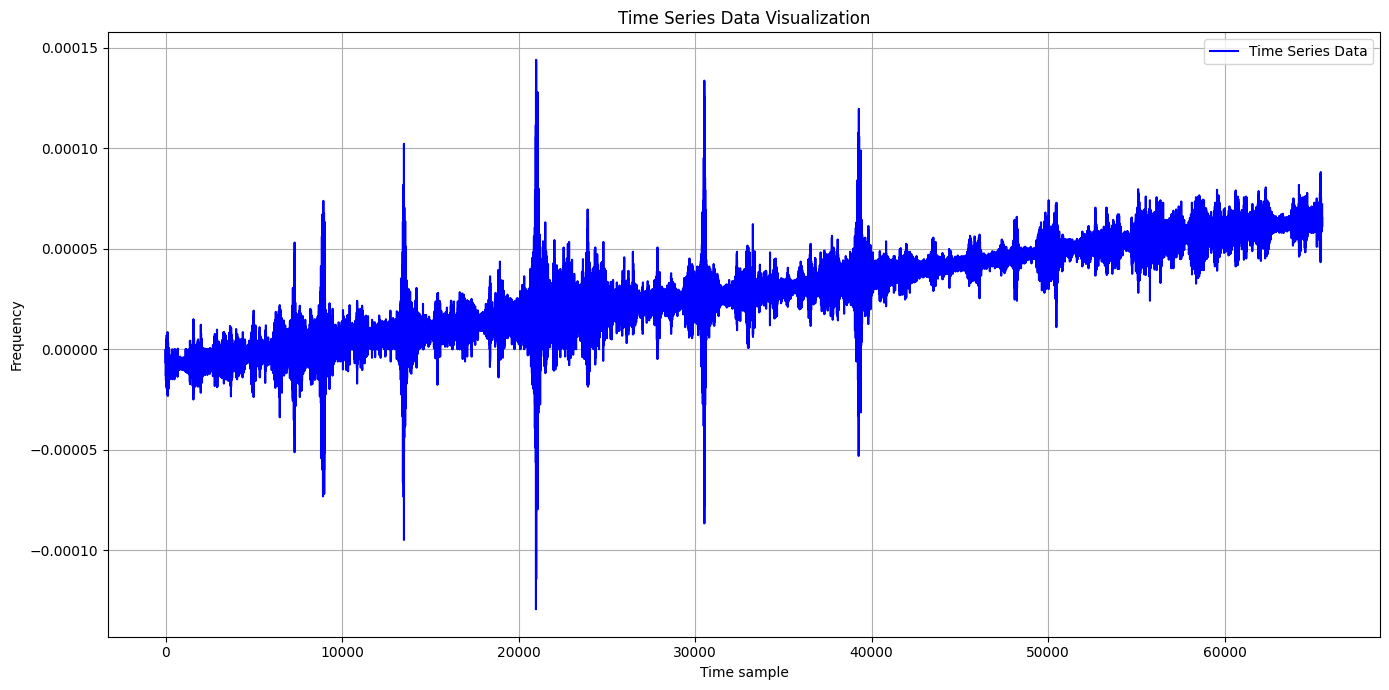

In [10]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Visualize the data
plt.figure(figsize=(14,7))
plt.plot(avt_data[29], label='Time Series Data', color='blue')
plt.title('Time Series Data Visualization')
plt.xlabel('Time sample')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
from scipy.stats import skew, kurtosis
import numpy as np

def sample_statistics(arr):
    return (np.min(arr), np.max(arr), np.std(arr), skew(arr), kurtosis(arr, fisher = True))

In [12]:
sample_statistics(avt_data[29])

(-0.0001293945,
 0.000144043,
 2.2116428504875117e-05,
 -0.08503763225466979,
 -0.7300311249355493)

In [13]:
signal = avt_data[29]
len(signal)

65536

### Remove constant offset from the signal

In [64]:
def remove_dc_component(signal):
    dc_removed_signal = signal - np.mean(signal)
    return dc_removed_signal

### Bandpass filter between 1 and 30 Hz

In [71]:
from scipy.signal import butter, lfilter

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Design and apply a Butterworth bandpass filter.
    Parameters:
        data (array): The signal to be filtered.
        lowcut (float): The lower frequency cut-off.
        highcut (float): The higher frequency cut-off.
        fs (int): The sampling rate of the data.
        order (int, optional): Order of the Butterworth filter. Default is 4.
    Returns:
        array: Filtered data.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    filtered_data = lfilter(b, a, data)
    return filtered_data

### Detrending 

In [74]:
from scipy.signal import detrend
def detrended_signal(filtered_signal):
    return detrend(filtered_signal)

### Standardization

In [81]:
def standardize_signal(signal):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    standard_signal = (signal - mean_signal) / std_signal
    return standard_signal

In [78]:
def preprocess(signal):
    low = 1 
    high  = 30
    sample_rate = 100
    return standardize_signal(detrended_signal(bandpass_filter(remove_dc_component(signal), low, high, sample_rate)))

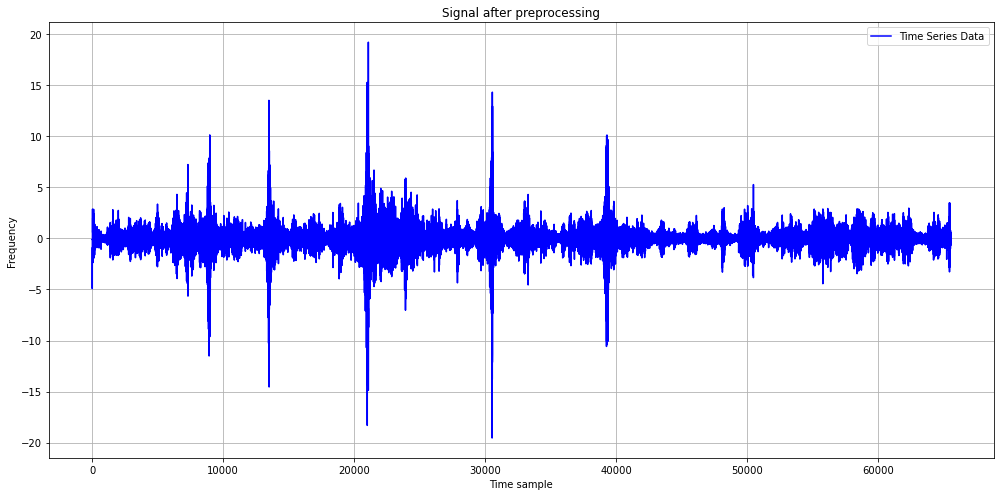

In [84]:
plt.figure(figsize=(14,7))
plt.plot(preprocess(avt_data[29]), label='Time Series Data', color='blue')
plt.title('Signal after preprocessing')
plt.xlabel('Time sample')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [116]:
def compute_time_domain_characteristics(signal):
    # Convert the signal to a numpy array for computation
    signal = np.array(signal)
    rms = np.sqrt(np.mean(np.square(signal))) 
    peak_to_peak = np.ptp(signal)  # ptp stands for 'peak to peak'
    crest_factor = np.max(np.abs(signal)) / rms
    mean_value = np.mean(signal)
    form_factor = rms / mean_value if mean_value != 0 else np.inf
    energy = np.sum(np.square(signal))
    power = energy / len(signal)
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    zero_crossing_rate = len(zero_crossings) / len(signal)
    # autocorrelation (for lag = 1 as example)
    autocorrelation_lag1 = np.correlate(signal, signal, mode='full')[len(signal)-1 + 1]

    return [
        rms,
        peak_to_peak,
        crest_factor,
        form_factor,
        energy,
        power,
        zero_crossing_rate,
        autocorrelation_lag1
    ]

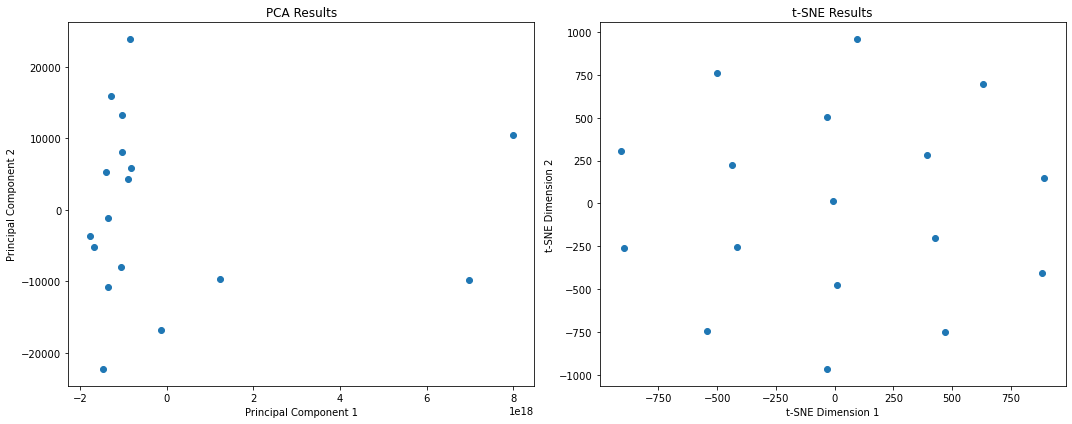

In [117]:
# characteristics for each signal
characteristics_data = [compute_time_domain_characteristics(preprocess(s)) for s in signals]

# PCA (using 2 components)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(characteristics_data)

# do 2-dimensional t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=250)
tsne_results = tsne.fit_transform(characteristics_data)

# Plot PCA and TSNE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(pca_results[:, 0], pca_results[:, 1])
ax1.set_title("PCA Results")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")

ax2.scatter(tsne_results[:, 0], tsne_results[:, 1])
ax2.set_title("t-SNE Results")
ax2.set_xlabel("t-SNE Dimension 1")
ax2.set_ylabel("t-SNE Dimension 2")

plt.tight_layout()
plt.show()


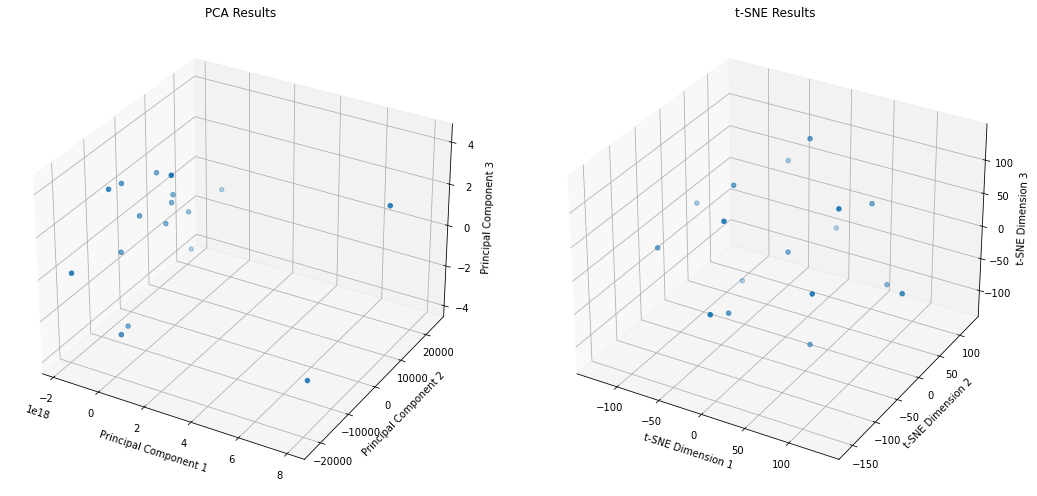

In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

characteristics_data = [compute_time_domain_characteristics(preprocess(s)) for s in signals]

# PCA (keeping 3 components)
pca = PCA(n_components=3)
pca_results = pca.fit_transform(characteristics_data)

# Perform 3-dimensional t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=250)
tsne_results = tsne.fit_transform(characteristics_data)

# Plot PCA and t-SNE results in 3D
fig = plt.figure(figsize=(15, 7))

# Plotting PCA Results
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_results[:, 0], pca_results[:, 1], pca_results[:, 2])
ax1.set_title("PCA Results")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.set_zlabel("Principal Component 3")

# Plotting t-SNE Results
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(tsne_results[:, 0], tsne_results[:, 1], tsne_results[:, 2])
ax2.set_title("t-SNE Results")
ax2.set_xlabel("t-SNE Dimension 1")
ax2.set_ylabel("t-SNE Dimension 2")
ax2.set_zlabel("t-SNE Dimension 3")

plt.tight_layout()
plt.show()


In [120]:
len(signals)

17

## Frequency domain characteristics

In [139]:
def compute_frequency_domain_characteristics(signal, fs=100):
    """
    frequency domain characteristics.
    :param signal: List or numpy array representing the signal.
    :param fs: Sampling frequency of the signal.
    :return: Dictionary containing frequency domain characteristics.
    """
    n = len(signal)
    
    # FT
    freqs = fftfreq(n, d=1/fs)
    magnitude = np.abs(fft(signal))
    
    # spec. density
    spectral_density = magnitude / n
    
    # fundamental freq.
    fundamental_frequency = freqs[np.argmax(magnitude)]
    
    half_power = np.max(magnitude) / 2
    lower_bandwidth_freq = freqs[np.argmax(magnitude[magnitude > half_power])]
    upper_bandwidth_frequ = freqs[::-1][np.argmax(magnitude[::-1][magnitude > half_power])]
    bandwidth = upper_bandwidth_frequ - lower_bandwidth_freq
    
    # find peaks in magnitude spectrum, sort them in decreasing order of magnitude
    peak_indices, _ = find_peaks(magnitude)
    sorted_peaks = sorted(peak_indices, key=lambda i: -magnitude[i])
    harmonics = freqs[sorted_peaks]
    
    if len(harmonics) > 1:
        thd = np.sqrt(sum(magnitude[sorted_peaks[1:]]**2)) / magnitude[sorted_peaks[0]] # total harmonic distrotion
    else:
        thd = 0
    
    # spectral flatnes
    geometric_mean = np.exp(np.mean(np.log(magnitude + 1e-10)))
    arithmetic_mean = np.mean(magnitude)
    spectral_flatness = geometric_mean / arithmetic_mean
    
    return [
        freqs, 
        magnitude,
        spectral_density,
        fundamental_frequency,
        bandwidth,
        harmonics,
        thd,
        spectral_flatness
    ]


In [140]:
characteristics_freq_data = [compute_frequency_domain_characteristics(preprocess(s)) for s in signals]
# (characteristics_freq_data[0][2]).shape gives (65530,)

## FFT

### Fourier transform is standardized before being plotted

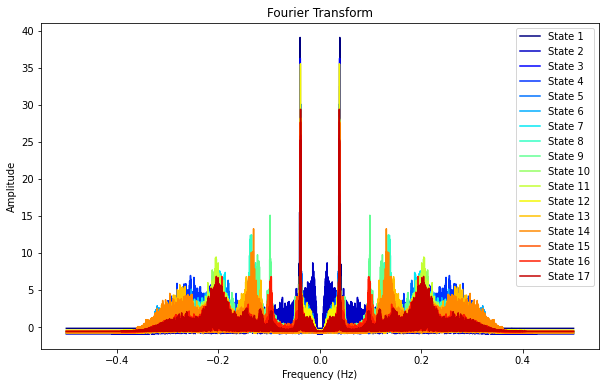

In [155]:
# FT
plt.figure(figsize=(10, 6))
# Loop through each dataset
for i in range(17):
    freqs = characteristics_freq_data[i][0]
    f_transform = characteristics_freq_data[i][1]
    # cycle thru a colormap
    unique_color = plt.cm.jet(i / 17)
    sns.lineplot(x = freqs, y = (f_transform - np.mean(f_transform))/np.std(f_transform), label=f'State {i+1}', color=unique_color)
#sns.lineplot(freqs, f_transform)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform')
plt.show()

In [170]:
preproc_sig = [preprocess(s) for s in signals]

## Spectrogram

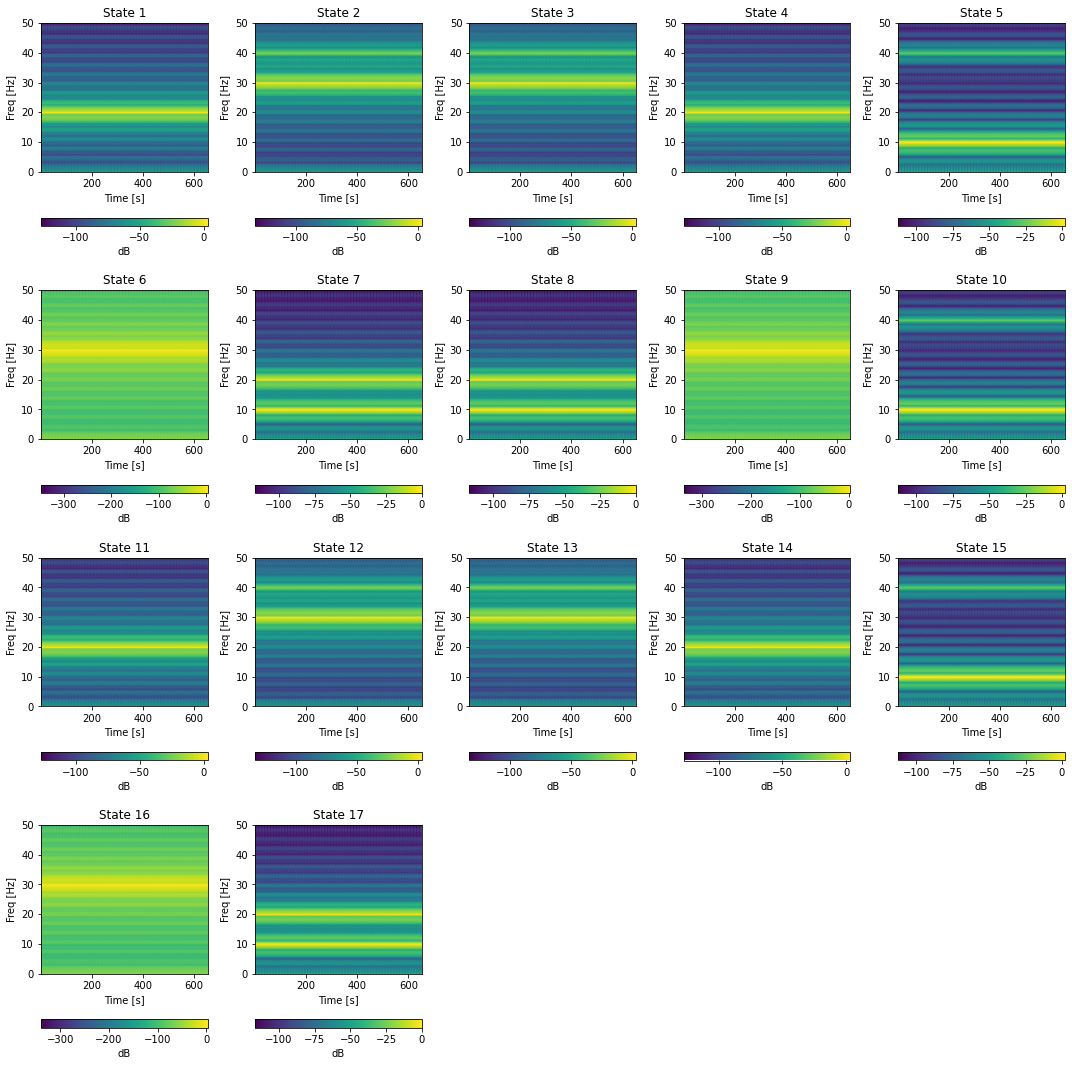

In [176]:
fs = 100  # 100 samples/second
T = 1.0 / fs  # time between consecutive samples
t = np.arange(0, len(signals[0])/fs, T)  # time vector

n_rows = 4  
n_cols = 5  
plt.figure(figsize=(15, 15))

# iterate through the signals
for i in range(len(preproc_sig)):
    
    # the i'th preprocessed signal 
    y = preproc_sig[i]
    
    # calculate the spectrogram
    f, t_spec, Sxx = spectrogram(y, fs)
    
    # select subplot
    plt.subplot(n_rows, n_cols, i+1)
    
    plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Freq [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f'State {i+1}')
    plt.colorbar(label='dB', orientation='horizontal', pad=0.2)

# put spacing between subplots
plt.tight_layout()
plt.show()